In [1]:
import scipy.io as sio
from matplotlib import pyplot as plt 
%matplotlib inline

from mne.viz import plot_compare_evokeds

import numpy as np 

import os 
from andante_pd_ft2mne import import2mne  

#matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/probands/data_cleaned_newfilt_subj_01k101k1.mat'


Test on all subjects 
--

In [19]:
#datadir = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/'
#datadir = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_ica_cleaned/'

datadir = '/home/nfarrugi/datasets/mpi_pd_cueing/data_ica_cleaned/'
resultdir = '/home/nfarrugi/datasets/mpi_pd_cueing/results_fkbest40_filter/'

import os 

allcontrols = os.listdir(os.path.join(datadir,'probands'))
allpatients = os.listdir(os.path.join(datadir,'patients'))

In [3]:
from utils import *

In [17]:
from andante_pd_ft2mne import import2mne  
from mne import Epochs,EpochsArray
from mne.channels import read_montage

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA

import mne
from mne.datasets import sample
from mne.decoding import GeneralizingEstimator
from mne.decoding import CSP
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from mne.preprocessing import Xdawn


def timegen_process_2x2(matfile,ncv=5,metric='accuracy',tmin=-0.05,tmax=0.15,pca=None,kbest = None,xdawn=None,
                        condnames=['iso_std','iso_dev'],condnames_2=['rnd_std','rnd_dev'],average=0,lpfilter=None):
    
    
    
    subjid = matfile[-8:-4]
    print("Subject : %s " % subjid)
    
    ## Open file 
    mneEpochs = import2mne(matfile,average=average)
    mneEpochs_short = mneEpochs.crop(tmin=tmin,tmax=tmax)
    
    
    montage = read_montage('standard_1020')

    mneEpochs_short.set_montage(montage)
    
    if lpfilter is not None:
        mneEpochs_short.filter(l_freq = None, h_freq = lpfilter)

    ## Perform Supervised Learning using Temporal Generalization 
    
    epochs = mneEpochs_short[condnames]
    epochs_cond2 = mneEpochs_short[condnames_2]
    
    if pca is not None:
        if kbest is not None:
            clf = make_pipeline(SelectKBest(k=kbest),PCA(n_components=pca),StandardScaler(),LogisticRegression())
        clf = make_pipeline(PCA(n_components=pca),StandardScaler(),LogisticRegression())

    elif kbest is not None:        
        clf = make_pipeline(SelectKBest(k=kbest),StandardScaler(),LogisticRegression())
    else:
        clf = make_pipeline(StandardScaler(),LogisticRegression())
    
    time_gen = GeneralizingEstimator(clf, scoring=metric, n_jobs=-2)

    time_gen_cond2 = GeneralizingEstimator(clf, scoring=metric, n_jobs=-2)

    
    # Get the labels
    labels = epochs.events[:, -1]
    labels_2 = epochs_cond2.events[:, -1]

    # Cross validator
    cv = StratifiedKFold(n_splits=ncv, shuffle=True, random_state=42)

    
    ### We will calculate a 2x2 matrix
    ### First, let's cal
    
    
    scores1_1 = []
    scores1_2 = []
    scores2_1 = []
    scores2_2 = []
    
    proba1_1 = []
    proba1_2 = []
    proba2_1 = []
    proba2_2 = []
    
    U1_1 = []
    U1_2 = []
    U2_1 = []
    U2_2 = []
    
    allpval1_1=[]
    allpval1_2=[]
    allpval2_1=[]
    allpval2_2=[]

    
    for train, test in cv.split(epochs, labels):
        for train2, test2 in cv.split(epochs_cond2,labels_2):

            ### Prepare all the data for the current CV folds 
            
             ### If XDawn, train two different XDawn and transform all data 
            
            if xdawn is not None:
                #Train XDawn for condition 1 
                xd_cond1 = Xdawn(n_components=xdawn,reg='shrunk')
                traindata = xd_cond1.fit_transform(epochs[train],labels[train])
                                                        
                #Transform test data and train data for condion1
                traindata2 = xd_cond1.transform(epochs_cond2[train2])            
                testdata = xd_cond1.transform(epochs[test])
                testdata2 = xd_cond1.transform(epochs_cond2[test2])
                
                
            else:
                traindata = epochs[train].get_data()
                traindata2 = epochs_cond2[train2].get_data()
                testdata = epochs[test].get_data()
                testdata2 = epochs_cond2[test2].get_data()

            
           
                
                
            
            
            
            
            # Train classifier1 on train data of condition 1 
            time_gen.fit(X=traindata, y=labels[train])

            # Train classifier2 on train data of condition 2 
            time_gen_cond2.fit(X=traindata2, y=labels_2[train2])
            
            # Test Classifier1 on test data of condition 1
            scores1_1.append(time_gen.score(X=testdata,y=labels[test]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen.predict_proba(X=testdata),y=labels[test])
            proba1_1.append(proba_av)
            U1_1.append(U)
            allpval1_1.append(allpval)
            
            
            # Test Classifier1 on test data of condition 2
            scores1_2.append(time_gen.score(X=testdata2,y=labels_2[test2]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen.predict_proba(X=testdata2),y=labels_2[test2])
            proba1_2.append(proba_av)
            U1_2.append(U)
            allpval1_2.append(allpval)
            
            # Test Classifier2 on test data of condition 1
            scores2_1.append(time_gen_cond2.score(X=testdata,y=labels[test]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen_cond2.predict_proba(X=testdata),y=labels[test])
            proba2_1.append(proba_av)
            U2_1.append(U)
            allpval2_1.append(allpval)
            
            # Test Classifier2 on test data of condition 2
            scores2_2.append(time_gen_cond2.score(X=testdata2,y=labels_2[test2]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen_cond2.predict_proba(X=testdata2),y=labels_2[test2])
            proba2_2.append(proba_av)
            U2_2.append(U)
            allpval2_2.append(allpval)

        
    scores1_1 = np.stack(scores1_1)
    
    scores1_2 = np.stack(scores1_2)
    
    scores2_1 = np.stack(scores2_1)
    
    scores2_2 = np.stack(scores2_2)
    
    proba1_1 = np.stack(proba1_1)
    
    proba1_2 = np.stack(proba1_2)
    
    proba2_1 = np.stack(proba2_1)
    
    proba2_2 = np.stack(proba2_2)
    
    U1_1 = np.stack(U1_1)
    U1_2 = np.stack(U1_2)
    U2_1 = np.stack(U2_1)
    U2_2 = np.stack(U2_2)
    
    allpval1_1 = np.stack(allpval1_1)
    allpval1_2 = np.stack(allpval1_2)
    allpval2_1 = np.stack(allpval2_1)
    allpval2_2 = np.stack(allpval2_2)
    
    scores = np.stack([scores1_1,scores1_2,scores2_1,scores2_2])
    allU = np.stack([U1_1,U1_2,U2_1,U2_2])
    allpvals = np.stack([allpval1_1,allpval1_2,allpval2_1,allpval2_2])
    allproba = np.stack([proba1_1,proba1_2,proba2_1,proba2_2])
     
    return scores,allU,allpvals,allproba,epochs.times[[0, -1, 0, -1]]

Formal structure

In [11]:
temporal = ['iso_std','rnd_std']
formal_iso = ['iso_std','iso_dev']
formal_rnd = ['rnd_std','rnd_dev']

tmin = -0.05
tmax = 0.52
ncv  = 2

#tmin = 0.25
#tmax = 0.40
#ncv  = 2

allscores_formal = []
allproba_formal = []

allU_formal = []
allpval_formal= []

listofsubj = [allcontrols,allpatients]



In [12]:
curfile = os.path.join(datadir,'probands',listofsubj[1][11])

print(curfile)

/home/nfarrugi/datasets/mpi_pd_cueing/data_ica_cleaned/probands/data_cleaned_subj_15c1.mat


In [18]:
curfile = os.path.join(datadir,'patients',listofsubj[1][11])

print(curfile)

subjid = curfile[-8:-4]

allscores,allU,allpvals,allproba,timepoints= timegen_process_2x2(curfile,metric='roc_auc',
                                                                 tmin=tmin,tmax=tmax,
                                                                 ncv=ncv,condnames=formal_iso,
                                                                 condnames_2=formal_rnd,
                                                                lpfilter=30,kbest=40)

/home/nfarrugi/datasets/mpi_pd_cueing/data_ica_cleaned/patients/data_cleaned_subj_15c1.mat
Subject : 15c1 
589 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

KeyboardInterrupt: 

with xdawn

/home/nfarrugi/datasets/mpi_pd_cueing/data_ica_cleaned/patients/data_cleaned_subj_15c1.mat


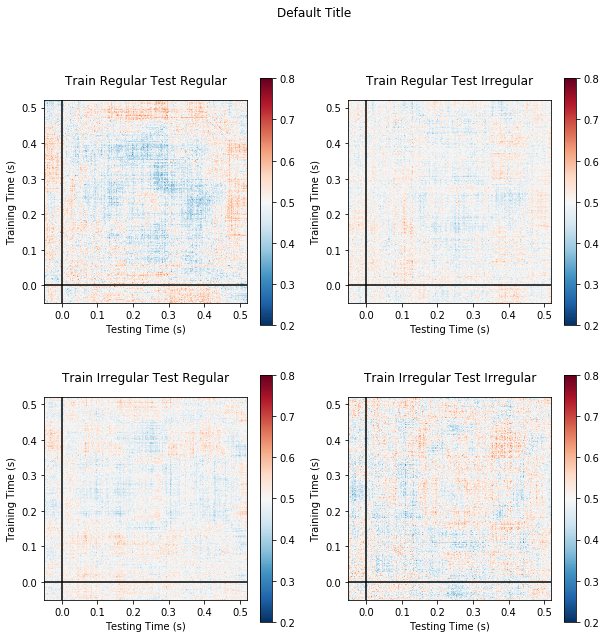

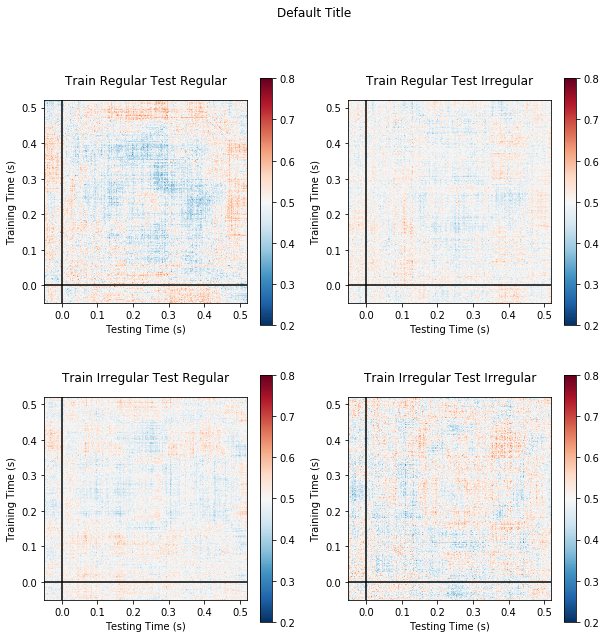

In [14]:
print(curfile)
plot_ROC_allcond(allscores,timepoints,figtitle='Default Title')

before xdawn

/home/nfarrugi/datasets/mpi_pd_cueing/data_ica_cleaned/probands/data_cleaned_subj_10k1.mat


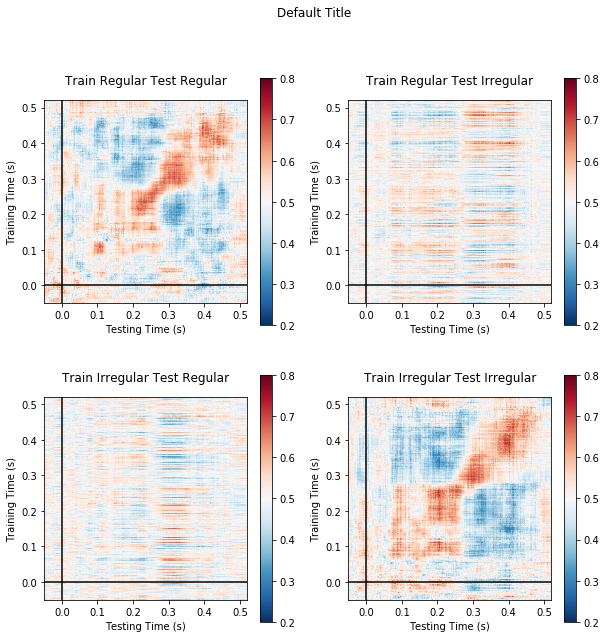

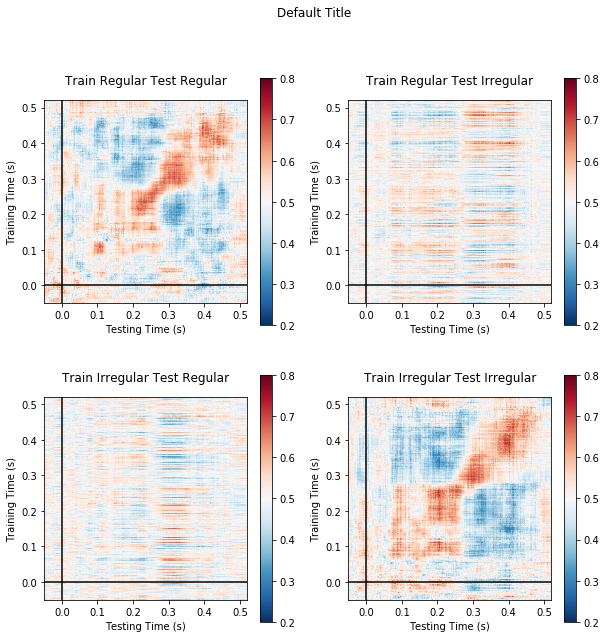

In [29]:
print(curfile)
plot_ROC_allcond(allscores,timepoints,figtitle='Default Title')

In [20]:
os.mkdir(resultdir)

On all subjects 

In [21]:
savenpz = True
for kk,group in enumerate(['probands','patients']):

    curlist = listofsubj[kk]
    
    for matfile in curlist:
        curfile = os.path.join(datadir,group,matfile)
        subjid = curfile[-8:-4]

        allscores,allU,allpvals,allproba,timepoints= timegen_process_2x2(curfile,metric='roc_auc',tmin=tmin,tmax=tmax,
                                                 ncv=ncv,condnames=formal_iso,condnames_2=formal_rnd,kbest=40,lpfilter=30)
        
       

        if savenpz:
            np.savez_compressed(os.path.join(resultdir,"180802_%s_formal_conditionwise.npz" % subjid),
                                scores=allscores,
                                proba = allproba,
                                U = allU,
                                pval=allpvals)

Subject : 10k1 
671 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s finished


Subject : 03k1 
621 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.6s finished


Subject : 12k1 
685 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.0s finished


Subject : 08k1 
587 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.2s finished


Subject : 18k1 
584 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.2s finished


Subject : 13k1 
633 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.7s finished


Subject : 14k1 
637 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.8s finished


Subject : 04k1 
670 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished


Subject : 02k1 
612 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.1s finished


Subject : 06k1 
562 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   25.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   25.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    7.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.8s finished


Subject : 09k1 
574 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    8.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.5s finished


Subject : 16k1 
647 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.0s finished


Subject : 19k1 
663 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.1s finished


Subject : 01k1 
657 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s finished


Subject : 17k1 
632 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.5s finished


Subject : 05k1 
613 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s finished


Subject : 20k1 
647 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.6s finished


Subject : 11k1 
679 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.3s finished


Subject : 15k1 
523 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   25.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   25.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.2s finished


Subject : 07k1 
631 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s finished


Subject : 11c1 
619 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished


Subject : 03m1 
654 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s finished


Subject : 10c1 
627 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.8s finished


Subject : 05c2 
599 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.1s finished


Subject : 07c2 
621 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s finished


Subject : 12c2 
583 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.9s finished


Subject : 17c2 
639 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s finished


Subject : 01c2 
640 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.9s finished


Subject : 08c3 
623 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.8s finished


Subject : 11c2 
609 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.6s finished


Subject : 04c1 
691 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished


Subject : 15c1 
589 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.6s finished


Subject : 10c2 
645 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s finished


Subject : 03c3 
650 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s finished


Subject : 03c1 
639 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished


Subject : 05c1 
659 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.1s finished


Subject : 08c1 
609 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.6s finished


Subject : 13c3 
602 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s finished


Subject : 13c1 
661 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.7s finished


Subject : 14c1 
631 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.8s finished


Subject : 09c2 
610 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.2s finished


Subject : 02m1 
608 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.7s finished


Subject : 08c2 
617 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s finished


Subject : 06c3 
592 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.1s finished


Subject : 06c2 
595 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s finished


Subject : 17c1 
616 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.7s finished


Subject : 01c3 
642 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s finished


Subject : 11c3 
629 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.8s finished


Subject : 03c2 
616 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished


Subject : 12c1 
589 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.5s finished


Subject : 01c1 
632 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s finished


Subject : 14c2 
592 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.1s finished


Subject : 10c3 
621 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.0s finished


Subject : 01m1 
566 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    9.4s finished


Subject : 02c3 
610 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.3s finished


Subject : 05c3 
637 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s finished


Subject : 09c3 
607 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.8s finished


Subject : 13c2 
611 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s finished


Subject : 02c2 
615 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished


Subject : 12c3 
586 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.9s finished


Subject : 04c3 
609 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.1s finished


Subject : 07c1 
619 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.0s finished


Subject : 09c1 
621 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.6s finished


Subject : 06c1 
632 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.4s finished


Subject : 07c3 
611 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.9s finished


Subject : 02c1 
577 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   10.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.8s finished


Subject : 04c2 
650 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.9s finished


Subject : 17c3 
627 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   28.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.7s finished


Subject : 14c3 
590 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   11.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished


Subject : 04m1 
675 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 221 samples (0.442 sec) selected


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   15.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.3s finished


note : takes approx 20 hours to run on the standard IA computer  (for PCA80perc)